In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from pysr import PySRRegressor
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from causallearn.search.ConstraintBased.PC import pc
from scipy.stats import ks_2samp

import functions

In [3]:
def fair_train_test_split(df, test_size=0.2,shreshold=0.999):
    """
    Split the data into training and testing sets until the K-S test is passed
    """
    stop=False
    i=0
    while stop == False:
        df_train, df_test = train_test_split(df, test_size=test_size, random_state=i)
        y_train = df_train['M_BH']
        y_test = df_test['M_BH']
        ks_test=ks_2samp(y_test,df['M_BH'])
        ks_train=ks_2samp(y_train,df['M_BH'])
        ks=ks_2samp(y_test,y_train)
        #print(ks_test[1],ks_train[1],ks[1])

        if ks_test[1] > shreshold and ks_train[1] > shreshold and ks[1] > shreshold:
            stop = True
            print(ks_test[1],ks_train[1],ks[1],i)
            print('K-S test passed!')
        else:
            i+=1
            #print('K-S test failed!')
    return df_train, df_test

In [4]:
low_scatter_para=['ETG','T-type','Bar', 'Disk', 'Ring', 'Core', 'Multiple', 'Compactness', 'AGN',
       'Pseudobulge', 'BCG', 'cD','M*_sph', 'M*_gal', 'log_B/T',
       'log_sigma0', 'log_R_e_sph_maj','log_R_e_sph_eq_kpc', 'log_n_sph_maj', 'log_n_sph_eq', 'log(I_e,sph,maj/M_Sun/pc^2)',
       'log(I_e,sph,eq/M_Sun/pc^2)', 'Concentration_Index',
       'avg_Rho_1kpc_Exact_All', 'r1_density_approx', 'log10(R10_kpc)',
       'logRho_R10_approx', 'log_rho10_Exact', 'log10(R90_kpc)',
       'logRho_R90_approx', 'log_rho_90_Exact_all', 'Rho_re_spatial',
       'SR_pc_All', 'Rho_SR_pc_All', 'CR_def1_approx_new',
       'Rho_cr_def1_approx_new', 'CR_def2_approx_new',
       'Rho_CR_def2_approx_new', 'Sr(pc)_2_using_Falserm_drho',
       'Log_Approx_Avg_density_10pc', 'log_Rho_e_Exact_new',
       'logRho_e_approx_New', 'logRho_soi_approx_new',
       'log_Rho_soi_exact_new', 'Avg_Rho_Re_Exact_all',
       'Avg_Rho_soi_exact_all', 'Avg_Rho_re_Exact_all', 'Rho_re_Exact_all',
       'Rho_r_soi_2BH_approx', 'Log_Avg_Rho_10kpc_approx',
       'Log_Avg_Rho_10kpc_exact_final', 'Log_Avg_Rho_100pc_approx',
       'Log_Avg_Rho_5kpc_approx', 'Log_Avg_rho_5kpc_exact_all', 'ube', 'bve',
       'dc', 'bvtc', 'bri25', 'mabs', 'blum', 'logblum', 'logSigma0sph',
       'LogSigma0', 'R10', 'logR10', 'logR10phi', 'Rh', 'logRh', 'logRhphi',
       'logHalo','M_BH']
low_scatter_para.append('M_BH_std')

In [5]:
df_full = pd.read_csv('SMBH_Data_0911.csv',header=1)
df_low_scatter = df_full[low_scatter_para].dropna(axis='index',how='any')
len(df_low_scatter)

100

0.9997865613606244 1.0 0.9950932360818906 42
K-S test passed!
Training Set RMSE:  0.16989543364964224
Test Set RMSE:  0.3707720337350176


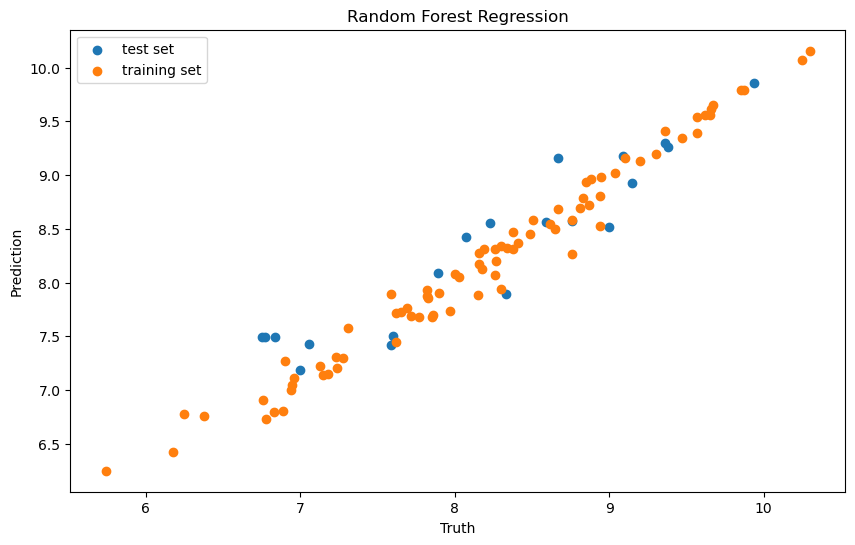

In [12]:
# randomly split the data into training and testing sets
df_train, df_test = fair_train_test_split(df_low_scatter, test_size=0.2,shreshold=0.99)


keys = low_scatter_para.copy()
keys.remove('M_BH')
keys.remove('M_BH_std')

X_train = df_train[keys]
y_train = df_train['M_BH']
X_test = df_test[keys]
y_test = df_test['M_BH']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a Random Forest Regressor
n_estimators = 100  # Number of trees in the forest
max_depth = None    # Maximum depth of the trees (None means unlimited)
random_state = 1    # Random seed for reproducibility

rf_regressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_regressor.predict(X_test)

# Calculate the training and test set loss (Mean Squared Error)
# functions.rmse
#train_loss = np.mean((y_train - rf_regressor.predict(X_train)) ** 2)
#test_loss = np.mean((y_test - y_pred) ** 2)
train_rmse = functions.rmse(y_train,rf_regressor.predict(X_train))
test_rmse = functions.rmse(y_test,y_pred)

print("Training Set RMSE: ",train_rmse)
print("Test Set RMSE: ",test_rmse)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label="test set")
plt.scatter(y_train, rf_regressor.predict(X_train), label="training set")
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.title("Random Forest Regression")
plt.legend()
plt.show()

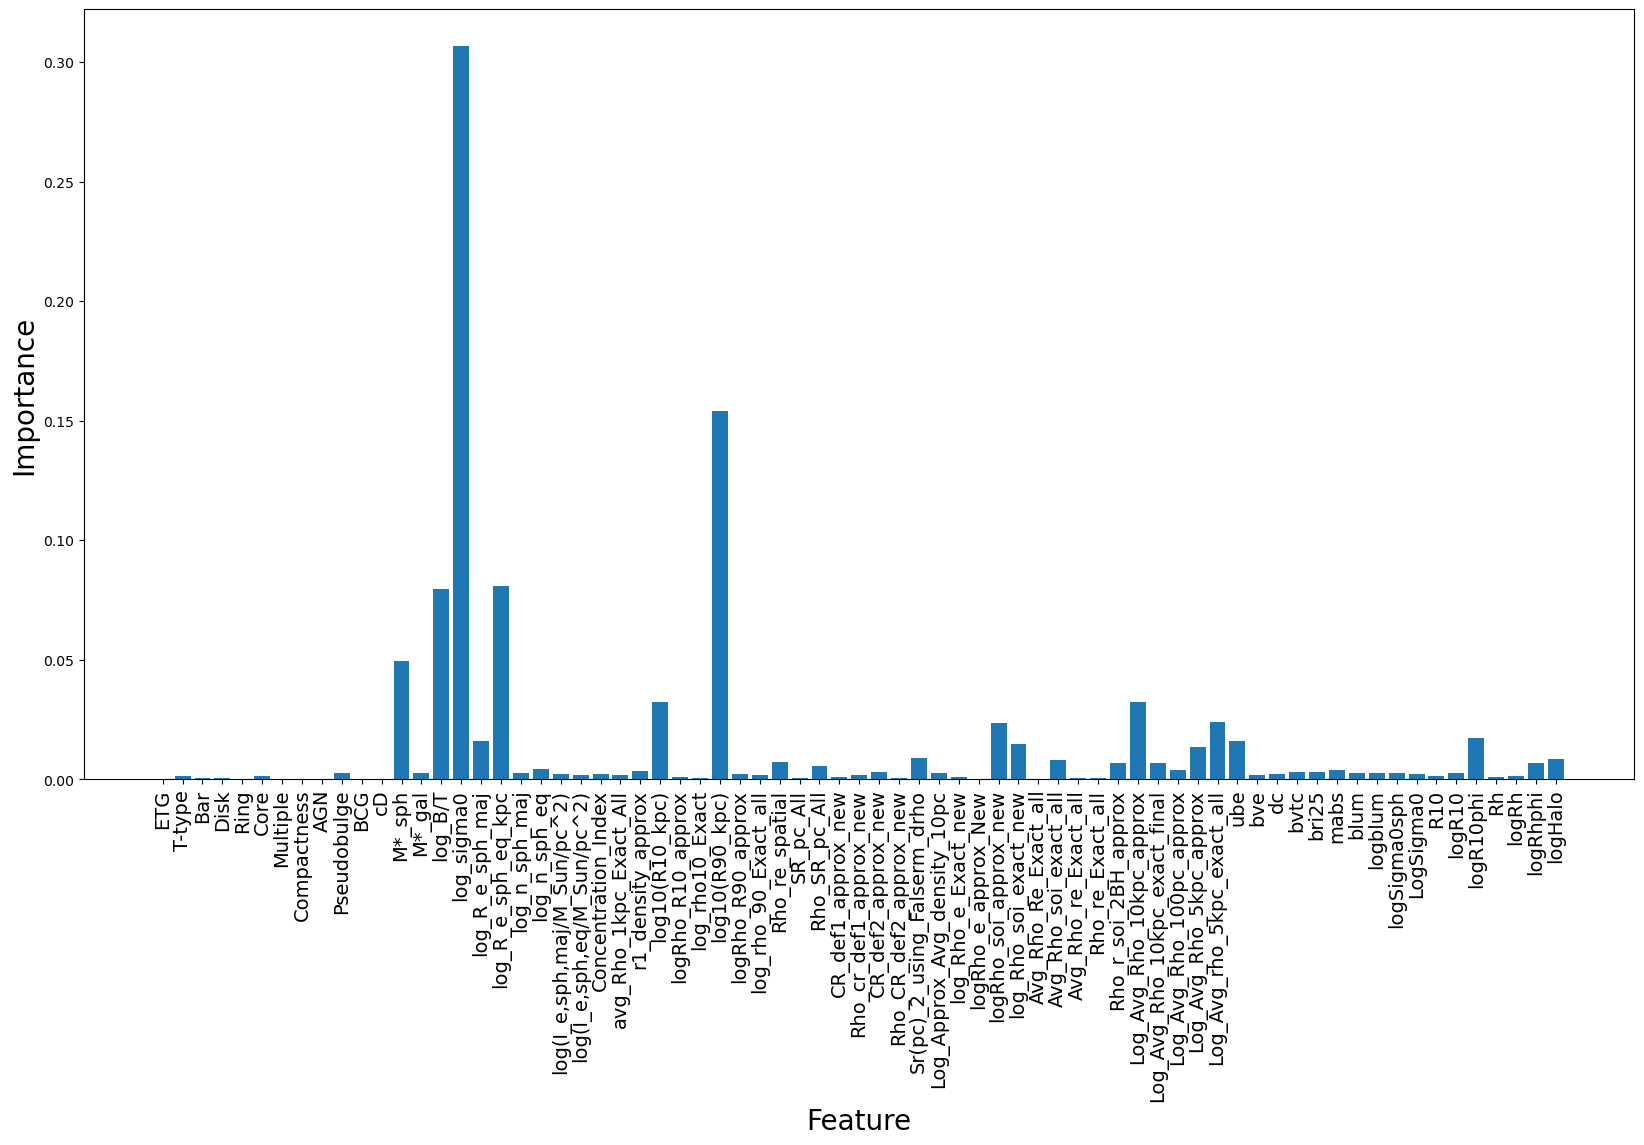

In [48]:
# Get feature importances
feature_importances = rf_regressor.feature_importances_

x_ticks_labels = X_train.columns
x_ticks=np.arange(len(feature_importances))
# Plot feature importances
plt.figure(figsize=(20, 10))
plt.bar(range(X_train.shape[1]), feature_importances, align="center")
plt.xlabel("Feature",fontsize=20)
plt.ylabel("Importance",fontsize=20)
plt.xticks(ticks=x_ticks,labels=x_ticks_labels, rotation=90, fontsize=14)
plt.show()

In [49]:
importance_order=feature_importances.argsort()[::-1]
importance=np.sort(feature_importances)[::-1]
#importance_order
for i in range(len(importance_order)):
    print(i+1,X_train.columns[importance_order[i]],importance[i])

1 log_sigma0 0.3068145141975535
2 log10(R90_kpc) 0.15408563983722884
3 log_R_e_sph_eq_kpc 0.08081932313455782
4 log_B/T 0.07950453861640697
5 M*_sph 0.04958641470161596
6 log10(R10_kpc) 0.03244764433897187
7 Log_Avg_Rho_10kpc_approx 0.0321845745199966
8 Log_Avg_rho_5kpc_exact_all 0.023876694114315762
9 logRho_soi_approx_new 0.023687748176179777
10 logR10phi 0.017279601306079632
11 log_R_e_sph_maj 0.016027211793991008
12 ube 0.015882653760567498
13 log_Rho_soi_exact_new 0.014625545283133425
14 Log_Avg_Rho_5kpc_approx 0.013548264188331868
15 Sr(pc)_2_using_Falserm_drho 0.009019645491536464
16 logHalo 0.008561180370202745
17 Avg_Rho_soi_exact_all 0.008164084402002074
18 Rho_re_spatial 0.007238499195247432
19 Log_Avg_Rho_10kpc_exact_final 0.0067973453454628005
20 Rho_r_soi_2BH_approx 0.006745051155767646
21 logRhphi 0.006725521021642184
22 Rho_SR_pc_All 0.005667867228472198
23 log_n_sph_eq 0.004208085946060246
24 mabs 0.0038676013320872436
25 Log_Avg_Rho_100pc_approx 0.0037206574951418165


In [50]:
X_train.columns[importance_order][:10]

Index(['log_sigma0', 'log10(R90_kpc)', 'log_R_e_sph_eq_kpc', 'log_B/T',
       'M*_sph', 'log10(R10_kpc)', 'Log_Avg_Rho_10kpc_approx',
       'Log_Avg_rho_5kpc_exact_all', 'logRho_soi_approx_new', 'logR10phi'],
      dtype='object')

In [51]:
top_ten=np.array(X_train.columns[importance_order][:10]).tolist()
#top_ten=['log_sigma0','log_B/T','logRho_soi_approx_new']

In [52]:
model=functions.test_relation(top_ten.copy(),obs=df_train,return_model=True,maxsize=10,ncyclesperiteration=5000,niterations=500)

80


/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1761: UserWarning: Note: you are running with 10 features or more. Genetic algorithms like used in PySR scale poorly with large numbers of features. Consider using feature selection techniques to select the most important features (you can do this automatically with the `select_k_features` parameter), or, alternatively, doing a dimensionality reduction beforehand. For example, `X = PCA(n_components=6).fit_transform(X)`, using scikit-learn's `PCA` class, will reduce the number of features to 6 in an interpretable way, as each resultant feature will be a linear combination of the original features. 
  warnings.warn(


parameters:
x 0 : log_sigma0
x 1 : log10(R90_kpc)
x 2 : log_R_e_sph_eq_kpc
x 3 : log_B/T
x 4 : M*_sph
x 5 : log10(R10_kpc)
x 6 : Log_Avg_Rho_10kpc_approx
x 7 : Log_Avg_rho_5kpc_exact_all
x 8 : logRho_soi_approx_new
x 9 : logR10phi
Eq. selected rmse: 0.2399340298875464


x4 - 0.36867632917074256*x8 - 1.3838923265177483

Eq. 0 rmse: 0.9092805672720262


8.214452450708531

Eq. 1 rmse: 0.3464883219848879


x4 - 2.3776001738506087

Eq. 2 rmse: 0.2929740900196288


3.9143558423387006*x0 + x5

Eq. 3 rmse: 0.2399340298875464


x4 - 0.36867632917074256*x8 - 1.3838923265177483

Eq. 4 rmse: 0.21646658147696027


3.9143558423387006*x0 + 0.32500397903789824*x1 - 0.32500397903789824*x8

Eq. 5 rmse: 0.20397671444461782


2.1350417621534366*x0 + x3 + 5.038628263646103 - x8/x0

In [53]:
y = df_test['M_BH'].to_numpy()
w = 1/df_test['M_BH_std'].to_numpy()**2

for i in range(len(model.equations_)):
    y_pred = model.predict(X_test[top_ten].to_numpy(),index=i)    
    print('Eq.',i,'test set rmse:',functions.wrmse(y,y_pred,w))
    display(model.sympy(index=i))

Eq. 0 test set rmse: 0.8989181400106324


8.214452450708531

Eq. 1 test set rmse: 0.6355768393840101


x4 - 2.3776001738506087

Eq. 2 test set rmse: 0.6863171522365519


3.9143558423387006*x0 + x5

Eq. 3 test set rmse: 0.534027246449647


x4 - 0.36867632917074256*x8 - 1.3838923265177483

Eq. 4 test set rmse: 0.48037644221752174


3.9143558423387006*x0 + 0.32500397903789824*x1 - 0.32500397903789824*x8

Eq. 5 test set rmse: 0.48602084029842396


2.1350417621534366*x0 + x3 + 5.038628263646103 - x8/x0

In [54]:
easy_obs_para=['LogSigma0','Concentration_Index','logSigma0sph','log_sigma0','dc','logRhphi','M*_sph','ube','bri25','bve','bvtc','logR10phi','M*_gal','log_B/T',
 'Pseudobulge','logRh','log_n_sph_eq','blum','log_R_e_sph_maj','logblum','AGN','Multiple','log_n_sph_maj','logR10','Ring','BCG','Disk','cD',
 'Bar','Core','Compactness','ETG','T-type','M_BH','log10(R10_kpc)','log10(R90_kpc)']
easy_obs_para.append('M_BH_std')

In [55]:
df_full = pd.read_csv('SMBH_Data_0911.csv',header=1)
df_easy_obs = df_full[easy_obs_para].dropna(axis='index',how='any')
len(df_easy_obs)

100

0.9999999999626806 1.0 0.999999822070167 5320
K-S test passed!
Training Set RMSE:  0.17288570827283414
Test Set RMSE:  0.45557501906930836


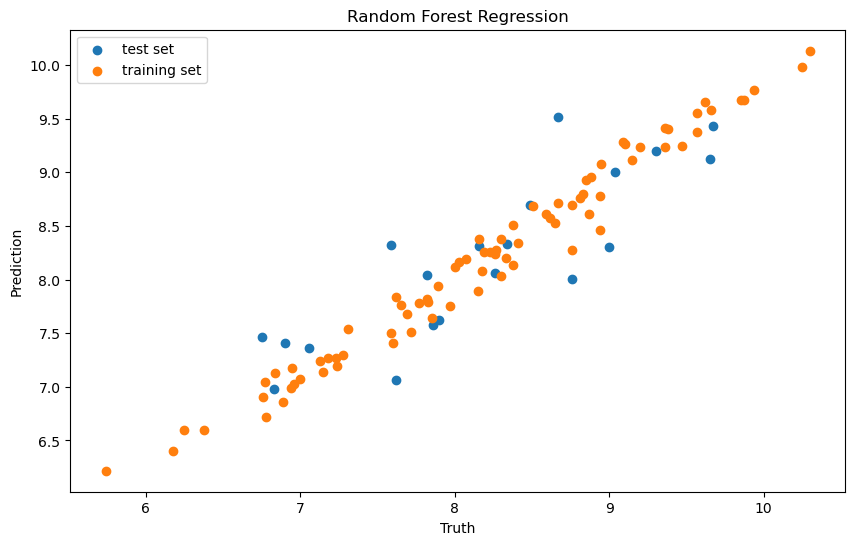

In [56]:
# randomly split the data into training and testing sets
df_train, df_test = fair_train_test_split(df_low_scatter, test_size=0.2,shreshold=0.99999)

keys = easy_obs_para.copy()
keys.remove('M_BH')
keys.remove('M_BH_std')

X_train = df_train[keys]
y_train = df_train['M_BH']
X_test = df_test[keys]
y_test = df_test['M_BH']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create a Random Forest Regressor
n_estimators = 100  # Number of trees in the forest
max_depth = None    # Maximum depth of the trees (None means unlimited)
random_state = 0    # Random seed for reproducibility

rf_regressor = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

# Fit the model to the training data
rf_regressor.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_regressor.predict(X_test)

# Calculate the training and test set loss (Mean Squared Error)
# functions.rmse
#train_loss = np.mean((y_train - rf_regressor.predict(X_train)) ** 2)
#test_loss = np.mean((y_test - y_pred) ** 2)
train_rmse = functions.rmse(y_train,rf_regressor.predict(X_train))
test_rmse = functions.rmse(y_test,y_pred)

print("Training Set RMSE: ",train_rmse)
print("Test Set RMSE: ",test_rmse)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, label="test set")
plt.scatter(y_train, rf_regressor.predict(X_train), label="training set")
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.title("Random Forest Regression")
plt.legend()
plt.show()

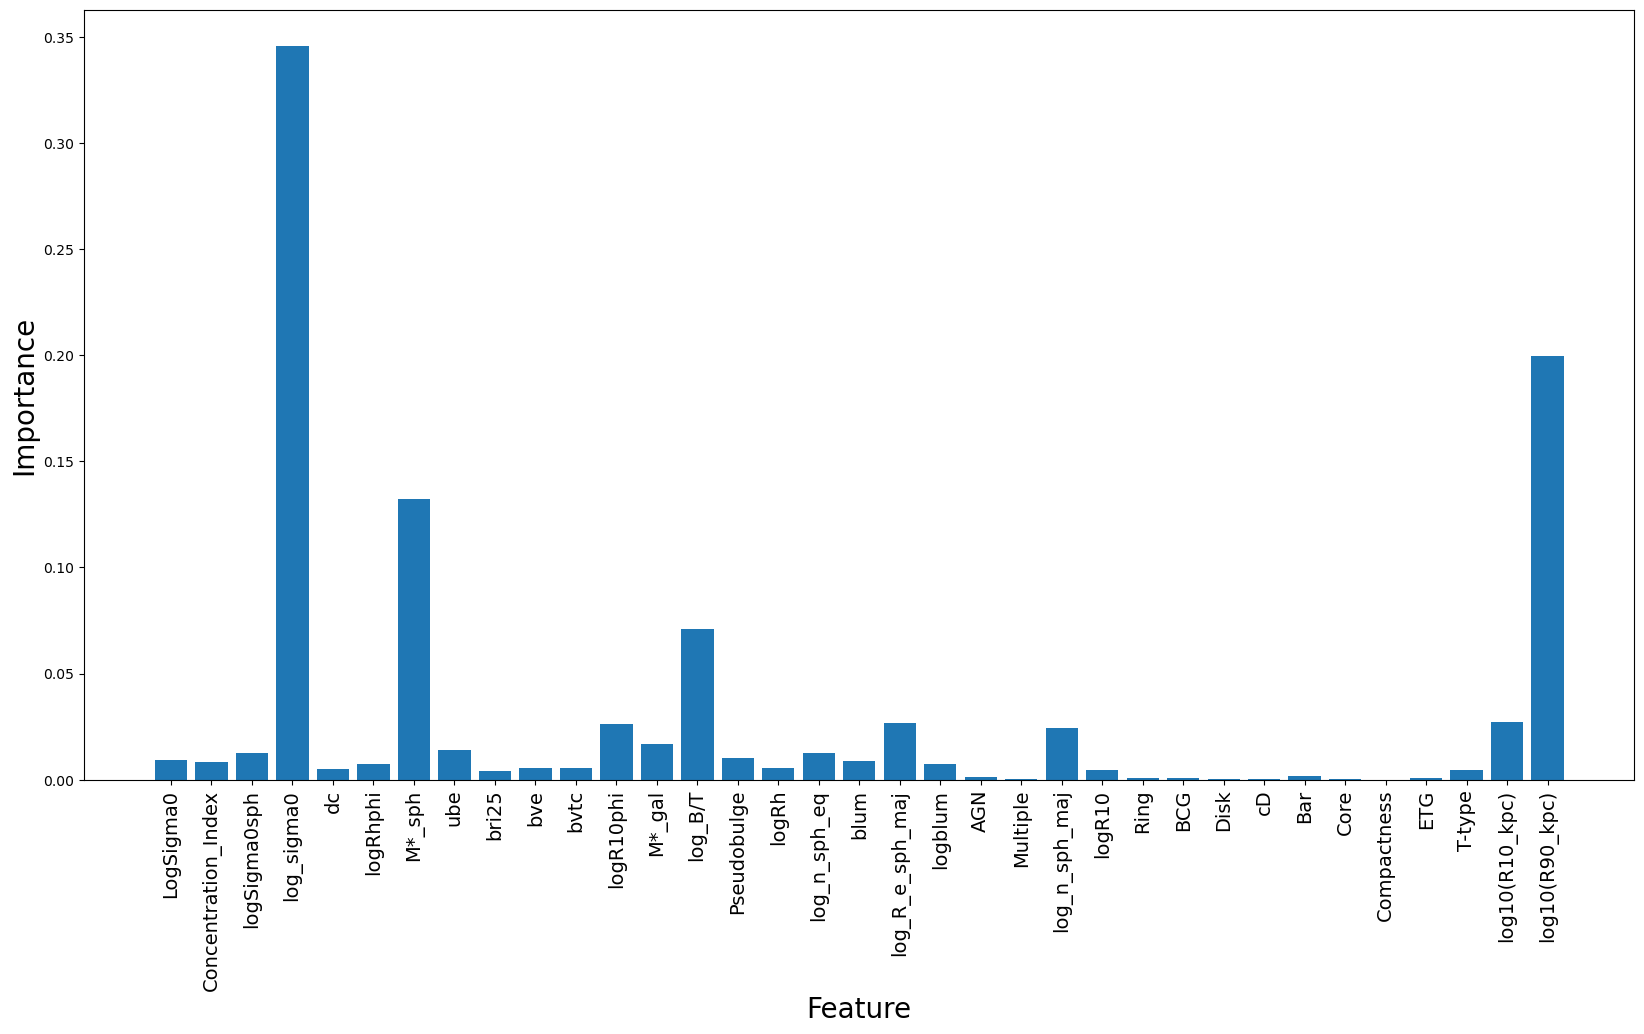

In [57]:
# Get feature importances
feature_importances = rf_regressor.feature_importances_

x_ticks_labels = X_train.columns
x_ticks=np.arange(len(feature_importances))
# Plot feature importances
plt.figure(figsize=(20, 10))
plt.bar(range(X_train.shape[1]), feature_importances, align="center")
plt.xlabel("Feature",fontsize=20)
plt.ylabel("Importance",fontsize=20)
plt.xticks(ticks=x_ticks,labels=x_ticks_labels, rotation=90, fontsize=14)
plt.show()

In [60]:
importance_order=feature_importances.argsort()[::-1]
importance=np.sort(feature_importances)[::-1]
#importance_order
for i in range(len(importance_order)):
    print(i+1,X_train.columns[importance_order[i]],importance[i])

1 log_sigma0 0.34566308425255643
2 log10(R90_kpc) 0.1994684732231762
3 M*_sph 0.13218720442893322
4 log_B/T 0.07088816099362545
5 log10(R10_kpc) 0.027180560432125033
6 log_R_e_sph_maj 0.0265605108029624
7 logR10phi 0.02619831079827406
8 log_n_sph_maj 0.024337751712071178
9 M*_gal 0.016809961999822945
10 ube 0.01376125429184938
11 logSigma0sph 0.012769287004044567
12 log_n_sph_eq 0.012680747650552087
13 Pseudobulge 0.010316635938572565
14 LogSigma0 0.009076123412039038
15 blum 0.008622399435440374
16 Concentration_Index 0.008067702762184279
17 logblum 0.007409279944704877
18 logRhphi 0.00732653020871345
19 bvtc 0.005571126340868976
20 logRh 0.005482727701953107
21 bve 0.005246077782727965
22 dc 0.005095738361983265
23 T-type 0.004553221620159292
24 logR10 0.004379037081076378
25 bri25 0.004043012968693617
26 Bar 0.001551429944253229
27 AGN 0.0010669490106246086
28 BCG 0.0009030592764380907
29 Ring 0.0006621374553014779
30 ETG 0.000525497843618254
31 Disk 0.0004922497099184576
32 Multipl

In [61]:
top_ten=np.array(X_train.columns[importance_order][:10]).tolist()

In [62]:
model=functions.test_relation(top_ten.copy(),obs=df_train,return_model=True,maxsize=15)
# model=functions.test_relation(top_ten.copy(),obs=df_train,return_model=True)

80


/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/zj448/miniconda3/lib/python3.9/site-packages/pysr/sr.py:1761: UserWarning: Note: you are running with 10 features or more. Genetic algorithms like used in PySR scale poorly with large numbers of features. Consider using feature selection techniques to select the most important features (you can do this automatically with the `select_k_features` parameter), or, alternatively, doing a dimensionality reduction beforehand. For example, `X = PCA(n_components=6).fit_transform(X)`, using scikit-learn's `PCA` class, will reduce the number of features to 6 in an interpretable way, as each resultant feature will be a linear combination of the original features. 
  warnings.warn(


parameters:
x 0 : log_sigma0
x 1 : log10(R90_kpc)
x 2 : M*_sph
x 3 : log_B/T
x 4 : log10(R10_kpc)
x 5 : log_R_e_sph_maj
x 6 : logR10phi
x 7 : log_n_sph_maj
x 8 : M*_gal
x 9 : ube
Eq. selected rmse: 0.2999089273757285


x2 + x7 - 2.9771849614297805

Eq. 0 rmse: 0.9092805672720262


8.214452450706329

Eq. 1 rmse: 0.3464883219848879


x2 - 2.3776001738511665

Eq. 2 rmse: 0.2999089273757285


x2 + x7 - 2.9771849614297805

Eq. 3 rmse: 0.2953573071801855


x2 + 0.776801535201388*x7 - 2.8433585569174173

Eq. 4 rmse: 0.29304277848984095


x0 + x2 - 4.6249046571508245

Eq. 5 rmse: 0.2888103132008429


x2 + 0.005819966237050955*x7*x8**2 - 2.815355770307593

Eq. 6 rmse: 0.2852228050959715


x2 + 0.4211753263933658*x5*x7*(-x4 + x7) - 2.5250290287793025

Eq. 7 rmse: 0.2774134368287479


-0.28447140454101927*x1 + x2 + 0.28447140454101927*x5 + x7 - 2.7908287496330911

In [63]:
y = df_test['M_BH'].to_numpy()
w = 1/df_test['M_BH_std'].to_numpy()**2

for i in range(len(model.equations_)):
    y_pred = model.predict(X_test[top_ten].to_numpy(),index=i)    
    print('Eq.',i,'test set rmse:',functions.wrmse(y,y_pred,w))
    display(model.sympy(index=i))

Eq. 0 test set rmse: 0.8989181400112365


8.214452450706329

Eq. 1 test set rmse: 0.6355768393840309


x2 - 2.3776001738511665

Eq. 2 test set rmse: 0.7112471535516742


x2 + x7 - 2.9771849614297805

Eq. 3 test set rmse: 0.6781787782140538


x2 + 0.776801535201388*x7 - 2.8433585569174173

Eq. 4 test set rmse: 0.6109084639350127


x0 + x2 - 4.6249046571508245

Eq. 5 test set rmse: 0.6850112671090682


x2 + 0.005819966237050955*x7*x8**2 - 2.815355770307593

Eq. 6 test set rmse: 0.7220793255749877


x2 + 0.4211753263933658*x5*x7*(-x4 + x7) - 2.5250290287793025

Eq. 7 test set rmse: 0.6786117813196001


-0.28447140454101927*x1 + x2 + 0.28447140454101927*x5 + x7 - 2.7908287496330911

In [71]:
X_test[top_ten].describe()

,log_sigma0,log10(R90_kpc),M*_sph,log_B/T,log10(R10_kpc),log_R_e_sph_maj,logR10phi,log_n_sph_maj,M*_gal,ube
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.289469,0.796807,10.651500,-0.318000,-0.643004,0.234500,9.824117,0.441500,10.969660,0.461250
std,0.166181,0.795125,0.625883,0.261888,0.467976,0.617205,0.304431,0.309911,0.460707,0.167119
min,1.997779,-0.315629,9.680000,-0.870000,-1.688471,-0.710000,9.207346,-0.150000,10.220000,0.070000
25%,2.193627,0.284375,10.185000,-0.502500,-0.903343,-0.275000,9.672927,0.245000,10.580000,0.455000
50%,2.313446,0.550934,10.495000,-0.310000,-0.707127,0.205000,9.843229,0.490000,10.825000,0.505000
75%,2.387419,1.325898,11.147500,-0.060000,-0.336490,0.662500,9.996293,0.645000,11.407500,0.565000
max,2.587980,2.694932,11.600000,0.000000,0.182853,1.570000,10.302046,1.000000,11.690000,0.640000


In [72]:
X_train[top_ten].describe()

,log_sigma0,log10(R90_kpc),M*_sph,log_B/T,log10(R10_kpc),log_R_e_sph_maj,logR10phi,log_n_sph_maj,M*_gal,ube
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,2.262741,0.847810,10.634000,-0.349750,-0.636730,0.258625,9.815159,0.499875,10.983750,0.463800
std,0.191670,0.849134,0.811641,0.341527,0.505254,0.664880,0.309986,0.267825,0.580465,0.192772
min,1.538951,-0.894568,8.030000,-1.160000,-1.722699,-1.230000,8.708445,-0.280000,9.190000,-0.495000
25%,2.145471,0.213908,10.065000,-0.580000,-1.019742,-0.265000,9.611815,0.357500,10.692500,0.397500
50%,2.286136,0.706261,10.655000,-0.280000,-0.675029,0.250000,9.802783,0.475000,10.980000,0.537500
75%,2.404113,1.620594,11.172500,-0.020000,-0.263761,0.775000,10.030347,0.712500,11.412500,0.571250
max,2.594437,2.613113,12.260000,0.000000,0.371948,1.730000,10.495264,1.000000,12.260000,0.855000
